# Genetic Algorithm Framework with MVO/RP models

Using Genetic Algorithm to find the optimal asset collections with Mean-variance/Risk parity models.

## Reference
- GA Framework: [DEAP](https://deap.readthedocs.io/en/master/)
- Multi-objective Algorithm: [NSGA2](https://deap.readthedocs.io/en/master/_modules/deap/tools/emo.html?highlight=selNSGA2#)
- Stopping Criteria/Performance Indicator: [Hypervolume](https://pymoo.org/misc/indicators.html#Hypervolume)


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from optimize_portfolio import optimize_portfolio

In [3]:
"""
Data Setup
"""

# Load the dataset
asset_index = pd.read_csv("data/aidx_eod_prices.csv")

unique_assets = asset_index['S_IRDCODE'].unique() # index_code list
print(unique_assets) # asset order

['000001.SH' '000002.SH' '000003.SH' ... '931493HKD210.CSI'
 '931493USD200.CSI' '931493USD210.CSI']


In [21]:
"""
Framework Setup
"""

MODEL_TYPE = 'MVO' # MVO, RP
TARGET_RETURN = 0.0 # target return
LOOKBACK_PERIOD = 180 # backtest day
RISK_FREE_RATE = 0.02 # risk-free rate
DATA_END_DATE = '20231223' # end date of data for model calculation
MAX_ASSETS_NUM = 10 # max number of assets

In [22]:
"""
Fitness Function (Regularization - Optional)
"""

# Fitness Function
def evaluate(individual):
    # Select assets based on the individual's binary vector
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]

    # If selected assets are empty (might be caused by mutation, crossover),
    # Set output to extreme situation
    if len(selected_assets) == 0:
        return 0, 0, 99999 # min return/sharpe, max volatility

    # Model output (new weights)
    new_weights, evaluation = optimize_portfolio(model_type=MODEL_TYPE, index_list=selected_assets, asset_index=asset_index,
                                                 data_end_date=DATA_END_DATE, backtest_day=LOOKBACK_PERIOD,
                                                 target_return=TARGET_RETURN, risk_free_rate=RISK_FREE_RATE)

    # Expected Return, Sharpe Ratio, Volatility
    expected_return, sharpe_ratio, volatility = evaluation

    return expected_return, sharpe_ratio, volatility

In [23]:
"""
GA Setup
"""

# Objective Setup: MAX(return, sharpe); MIN(volatility) [Equally-weighed]
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Individual Creation Func (Clustering - Optional)
def create_individual():
    individual = [random.randint(0, 1) for _ in range(len(unique_assets))]
    if sum(individual) == 0:  # If all zeros, randomly set one to 1
        individual[random.randint(0, len(unique_assets) - 1)] = 1
    return individual

# GA Initialization
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [24]:
"""
GA Algorithms Registration (Crossover, Mutation, Selection)
"""

# NSGA-II
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selNSGA2)

In [25]:
"""
GA Stopping Criteria (Optional)
"""

# Method 1 - Stable Pareto Front
def is_pareto_stable(history, gen, stability_threshold=10):
    if gen < stability_threshold:
        return False
    last_fronts = history[-stability_threshold:]
    return all(last_fronts[-1] == front for front in last_fronts)

# Method 2 - Stable Pareto Front Size
def is_pareto_size_stable(history, stability_threshold=50, relative_range=0.05):
    if len(history) < stability_threshold:
        return False

    sizes = [len(front) for front in history[-stability_threshold:]]
    max_size = max(sizes)
    min_size = min(sizes)

    if max_size == 0:
        return False

    size_fluctuation = (max_size - min_size) / max_size
    return size_fluctuation <= relative_range

# Method 3 - No Significant Improvements
def no_significant_improvements(history, gen, stability_threshold=50, improvement_threshold=0.01):
    if gen < stability_threshold:
        return False
    recent_hvs = history[-stability_threshold:]
    return all((hv - min(recent_hvs)) / hv < improvement_threshold for hv in recent_hvs)

In [26]:
from deap.algorithms import varAnd

""""
Run Genetic Algorithm
"""

# Running the GA
def run_ga(pop_size, num_generations):
    # Records
    pop = toolbox.population(n=pop_size)
    hof = tools.ParetoFront()
    logbook = tools.Logbook()
    stats = tools.Statistics(lambda ind: ind.fitness.values)

    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # Refactor eaSimple with stopping criteria
    def eaSimpleMod(cxpb, mutpb):
        logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

        hv_history = [] # improvement record (using hypervolume)
        pareto_history = [] # pareto record

        # Begin the generational process
        for gen in range(num_generations):
            # Select the next generation individuals
            offspring = toolbox.select(pop, len(pop))

            # Vary the pool of individuals
            offspring = varAnd(offspring, toolbox, cxpb, mutpb)

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            # Update the hall of fame with the generated individuals
            if hof is not None:
                hof.update(offspring)
                pareto_history.append(list(hof)) # update the pareto history

            # Replace the current population by the offspring
            pop[:] = offspring

            # Append the current generation statistics to the logbook
            record = stats.compile(pop) if stats else {}
            logbook.record(gen=gen, nevals=len(invalid_ind), **record)
            print(logbook.stream)

            # Calculate hypervolume of halloffame
            modified_front = [] # negate third objective (min volatility)
            for ind in hof:
                modified_ind = toolbox.clone(ind) # clone individual
                modified_values = [ind.fitness.values[0], ind.fitness.values[1], -ind.fitness.values[2]]
                modified_ind.fitness.values = tuple(modified_values)
                modified_front.append(modified_ind)
            hv = tools.hypervolume(modified_front)
            hv_history.append(hv)

            # Stopping Criteria
            if no_significant_improvements(hv_history, gen) and is_pareto_size_stable(pareto_history):
                print(f"Stopping GA at generation {gen}")
                break

    # Execute evolutionary algorithm
    # pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof,  verbose=True) # without stopping criteria
    eaSimpleMod(0.7, 0.2) # with stopping criteria

    return pop, hof, stats, logbook

# GA run
population, pareto_front, stats, logbook = run_ga(50, 200)  # X individuals, Y generations

gen	nevals	avg                                              	std                                           	min                                  	max                                           
0  	50    	[ 6.83285746e-02 -1.07618895e-02  2.15535639e+03]	[1.02495112e-01 8.58306196e-02 1.39819004e+04]	[-0.05221786 -0.61135544  0.11812745]	[3.59074338e-01 6.86832984e-03 9.99990000e+04]
1  	39    	[ 6.67213418e-02 -2.29412673e-02  1.44433443e+02]	[1.00581559e-01 1.20131896e-01 2.94716014e+02]	[-0.05221786 -0.61135544  0.11812745]	[3.59074338e-01 6.86832984e-03 1.63344785e+03]
2  	39    	[ 7.03330597e-02 -1.09247942e-02  2.14146459e+03]	[9.94436699e-02 8.58015357e-02 1.39827416e+04]	[-0.05221786 -0.61135544  0.11812745]	[3.59074338e-01 6.86832984e-03 9.99990000e+04]
3  	33    	[ 7.02835194e-02 -1.08144840e-02  2.14225258e+03]	[9.94621622e-02 8.58202031e-02 1.39826341e+04]	[-0.05221786 -0.61135544  0.11812745]	[3.59074338e-01 6.86832984e-03 9.99990000e+04]
4  	44    	[ 6.20210403e-02 -2.3034

KeyboardInterrupt: 

In [ ]:
"""
Pareto Front
"""

# Retrieve Weights/evaluations
def get_weights_evaluations(individual):
    selected_assets = [asset for asset, include in zip(unique_assets, individual) if include]
    new_weights, evaluation = optimize_portfolio(model_type=MODEL_TYPE, index_list=selected_assets, asset_index=asset_index,
                                                 data_end_date=DATA_END_DATE, backtest_day=LOOKBACK_PERIOD,
                                                 target_return=TARGET_RETURN, risk_free_rate=RISK_FREE_RATE)
    return new_weights, evaluation

# Retrieve and store weights/evaluations
individual_weights = {str(ind): get_weights_evaluations(ind)[0] for ind in pareto_front}
individual_evaluations = {str(ind): get_weights_evaluations(ind)[1] for ind in pareto_front}

# Output
for i, ind in enumerate(pareto_front):
    print(f"Pareto Front {i}")
    print(f"Individual: {ind}")
    print(f"Weights: {individual_weights[str(ind)]}")
    print(f"Evaluations: {individual_evaluations[str(ind)]}")
    print("")

Pareto Front 0
Individual: [0, 0, 0, 1, 0]
Weights: [1.]
Evaluations: (0.20038395247141408, 0.00029950409582545903, 602.2754112068499)

Pareto Front 1
Individual: [0, 0, 0, 1, 1]
Weights: [6.88743993e-04 9.99311256e-01]
Evaluations: (0.06102252601615469, 0.005173937546273701, 7.9286859667835285)

Pareto Front 2
Individual: [0, 0, 0, 0, 1]
Weights: [1.]
Evaluations: (0.060926475516676376, 0.005174583250571406, 7.909134617199761)

Pareto Front 3
Individual: [0, 1, 0, 1, 1]
Weights: [0.20490372 0.00086887 0.79422741]
Evaluations: (0.05348542619609125, 0.00525527320132909, 6.371776483023297)

Pareto Front 4
Individual: [0, 1, 0, 0, 1]
Weights: [0.20486134 0.79513866]
Evaluations: (0.05336581965956889, 0.005262474831093742, 6.340328596428499)

Pareto Front 5
Individual: [0, 1, 0, 0, 0]
Weights: [1.]
Evaluations: (0.024020264710543214, 0.014245003999866139, 0.2822227856574131)



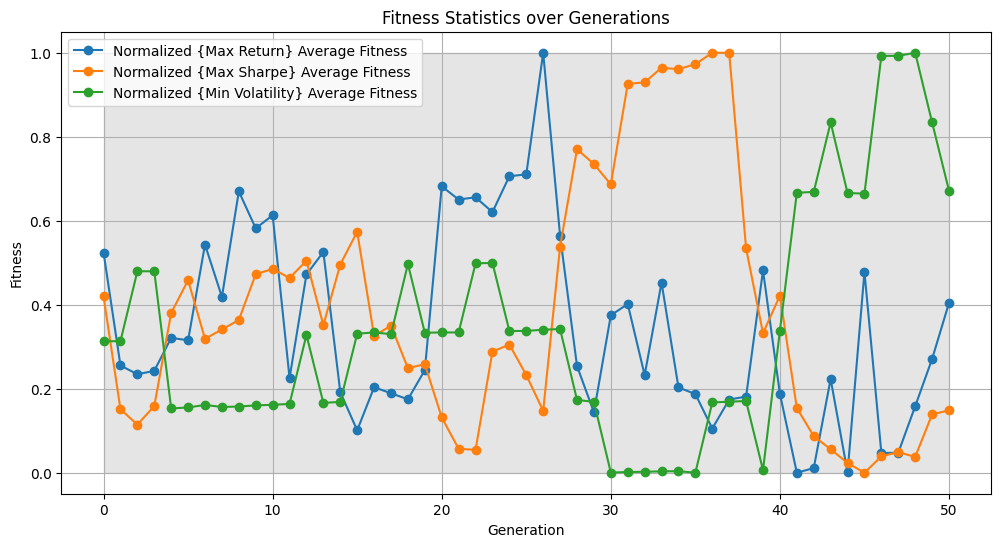

In [ ]:
"""
Evolutionary Visualization
"""

# Extracting the statistics
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
std_fitness = logbook.select("std")
min_fitness = logbook.select("min")
max_fitness = logbook.select("max")

# Normalization function
def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Normalizing the average fitness for each objective
normalized_avg_fitness = [normalize([fit[i] for fit in avg_fitness]) for i in range(len(avg_fitness[0]))]

# Plotting for multiple objectives
plt.figure(figsize=(12, 6))

# Each objective (Avg)
plt.plot(gen, normalized_avg_fitness[0], label=f'Normalized {{Max Return}} Average Fitness', marker='o')
plt.plot(gen, normalized_avg_fitness[1], label=f'Normalized {{Max Sharpe}} Average Fitness', marker='o')
plt.plot(gen, normalized_avg_fitness[2], label=f'Normalized {{Min Volatility}} Average Fitness', marker='o')

# Misc
plt.fill_between(gen, 0, 1, alpha=0.2, color='grey')
plt.title('Fitness Statistics over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()
